# **Import Libraries**

In [36]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# **Load Data**

In [37]:
# Load Data
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
holidays_events = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv', parse_dates=['date'])
sample_submission = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

# **Display Data**

In [38]:
# Display first few rows of each DataFrame
print("Train Data:")
display(train.head())

print("\nTest Data:")
display(test.head())

print("\nStores Data:")
display(stores.head())

Train Data:


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0



Test Data:


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0



Stores Data:


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [39]:
print("\nOil Data:")
display(oil.head())

print("\nHolidays & Events Data:")
display(holidays_events.head())

print("\nTransactions Data:")
display(transactions.head())

print("\nSample Submission:")
display(sample_submission.head())


Oil Data:


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20



Holidays & Events Data:


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False



Transactions Data:


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922



Sample Submission:


,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


# **Data Exploration**

## **Distribution of Sales**

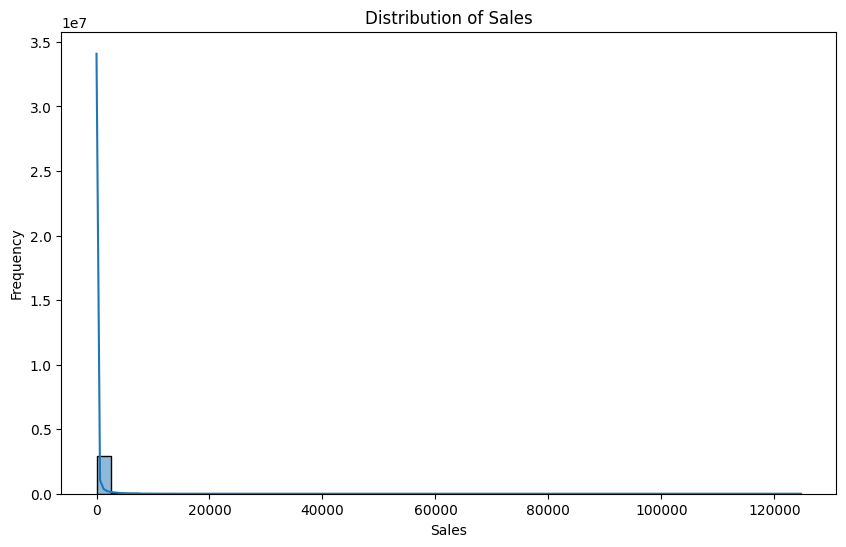

In [40]:
# Distribution of Sales
plt.figure(figsize=(10,6))
sns.histplot(train['sales'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

## **Missing Values**

In [41]:
# Function to Check Missing Values
def missing_values(df, name):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if not missing.empty:
        print(f"Missing values in {name}:")
        print(missing)
        print("\n")
    else:
        print(f"No missing values in {name}.\n")

# Check Missing Values
missing_values(train, 'train.csv')
missing_values(test, 'test.csv')
missing_values(stores, 'stores.csv')
missing_values(oil, 'oil.csv')
missing_values(holidays_events, 'holidays_events.csv')
missing_values(transactions, 'transactions.csv')
missing_values(sample_submission, 'sample_submission.csv')

No missing values in train.csv.

No missing values in test.csv.

No missing values in stores.csv.

Missing values in oil.csv:
dcoilwtico    43
dtype: int64


No missing values in holidays_events.csv.

No missing values in transactions.csv.

No missing values in sample_submission.csv.



# **Data Visualization**

## **Sales Over Time**

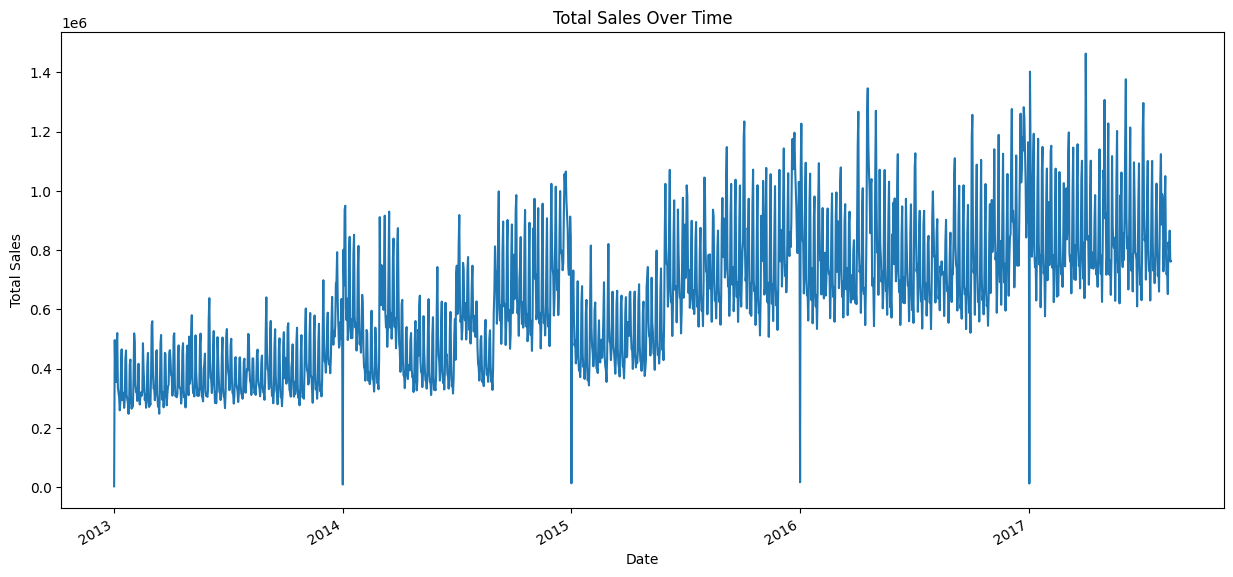

In [42]:
plt.figure(figsize=(15,7))
train.groupby('date')['sales'].sum().plot()
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

## **Sales by Store**

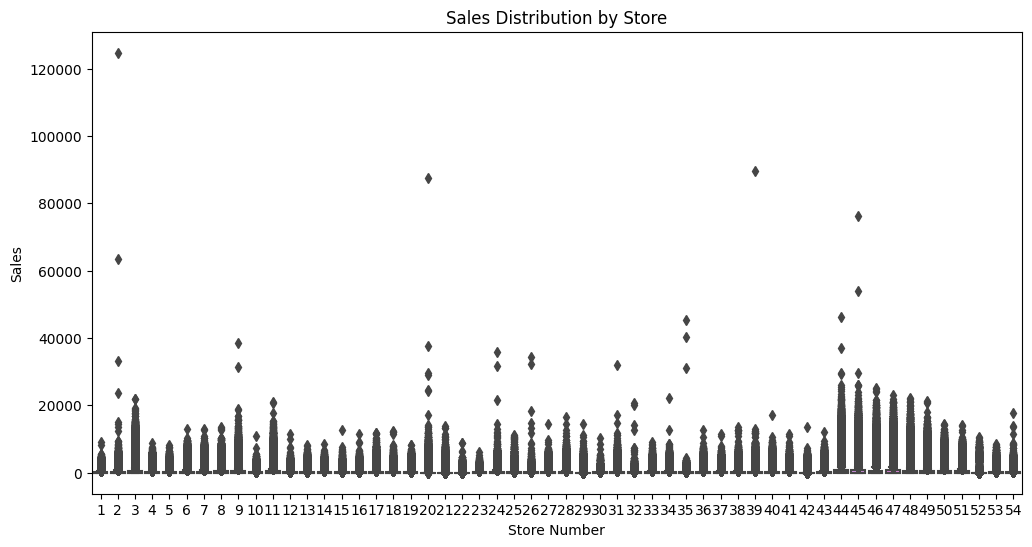

In [43]:
plt.figure(figsize=(12,6))
sns.boxplot(x='store_nbr', y='sales', data=train)
plt.title('Sales Distribution by Store')
plt.xlabel('Store Number')
plt.ylabel('Sales')
plt.show()

## **Sales by Product Family**

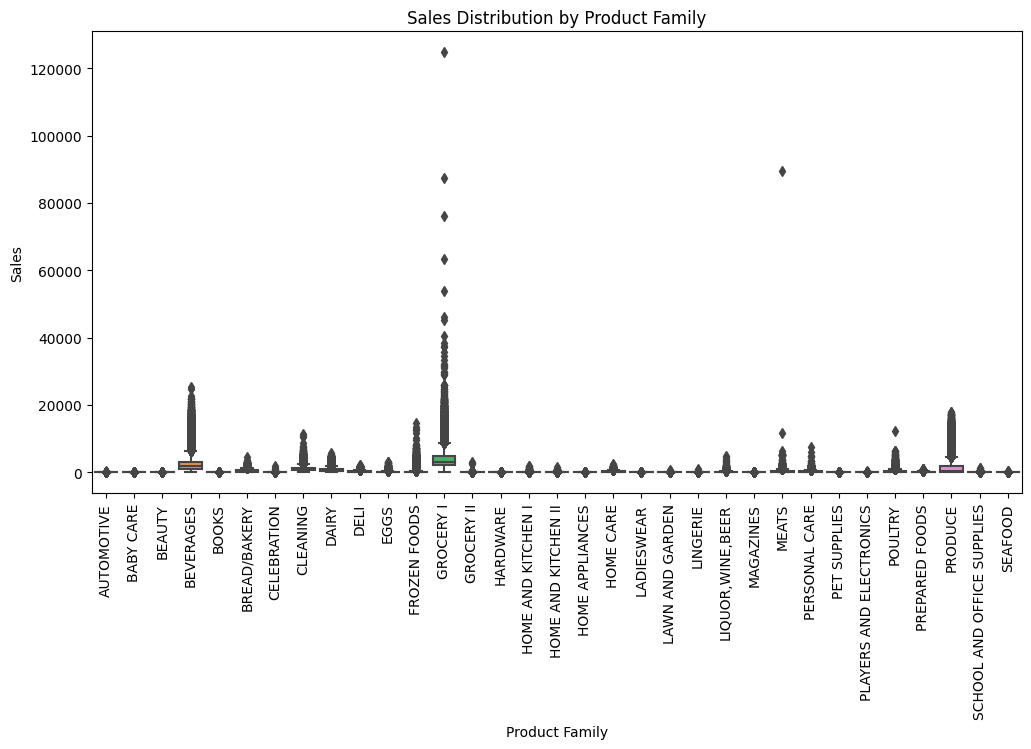

In [44]:
plt.figure(figsize=(12,6))
sns.boxplot(x='family', y='sales', data=train)
plt.title('Sales Distribution by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.show()

## **Correlation Heatmap**

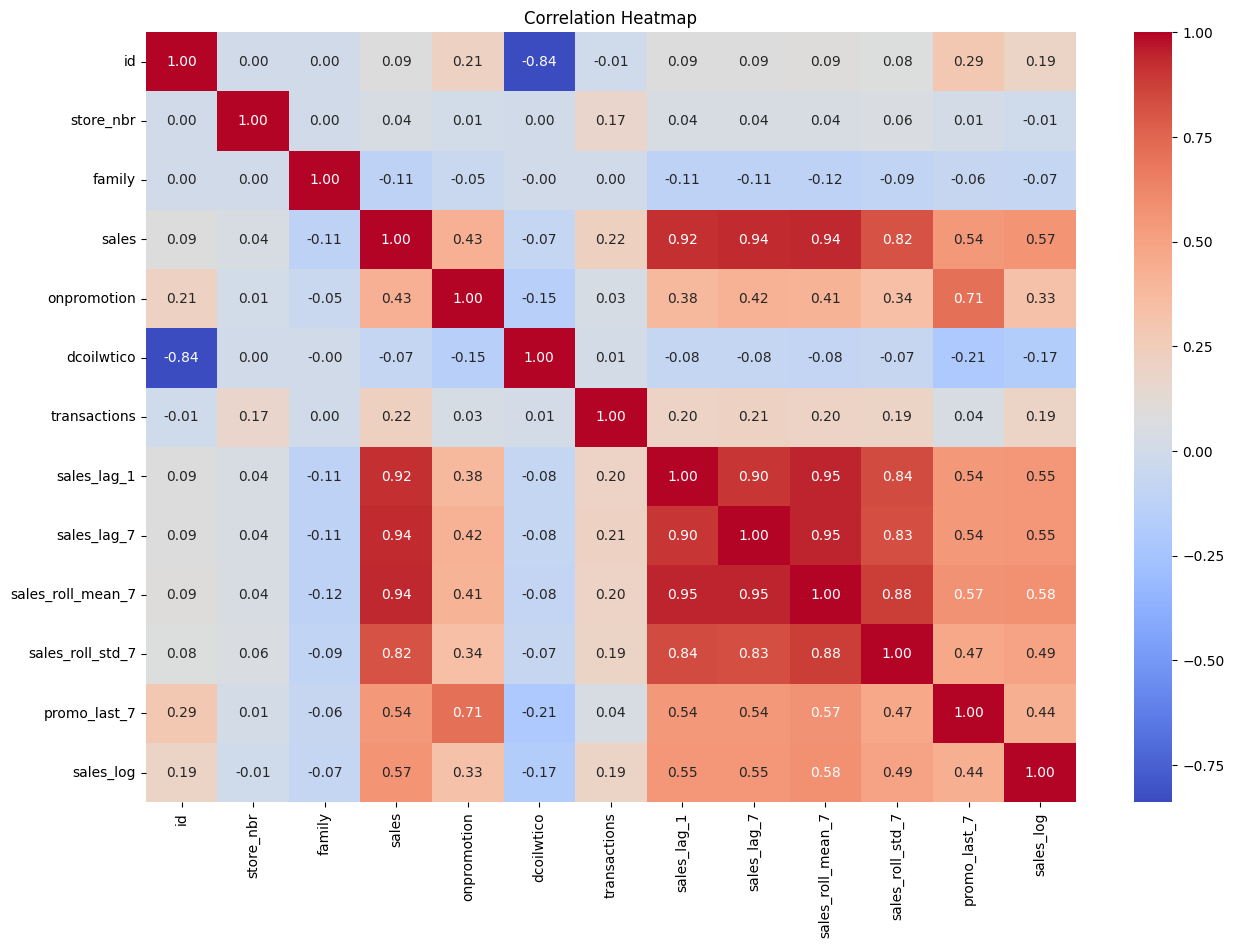

In [45]:
# Correlation Heatmap
numeric_df = train_processed.select_dtypes(include=[np.number])
plt.figure(figsize=(15,10))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## **Impact of Promotions on Sales**

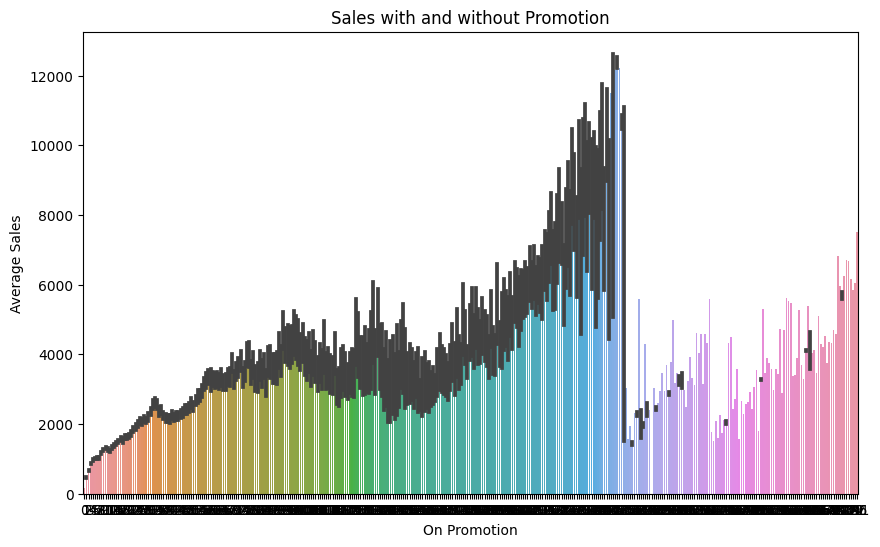

In [46]:
plt.figure(figsize=(10,6))
sns.barplot(x='onpromotion', y='sales', data=train)
plt.title('Sales with and without Promotion')
plt.xlabel('On Promotion')
plt.ylabel('Average Sales')
plt.show()

## **Oil Prices Over Time**

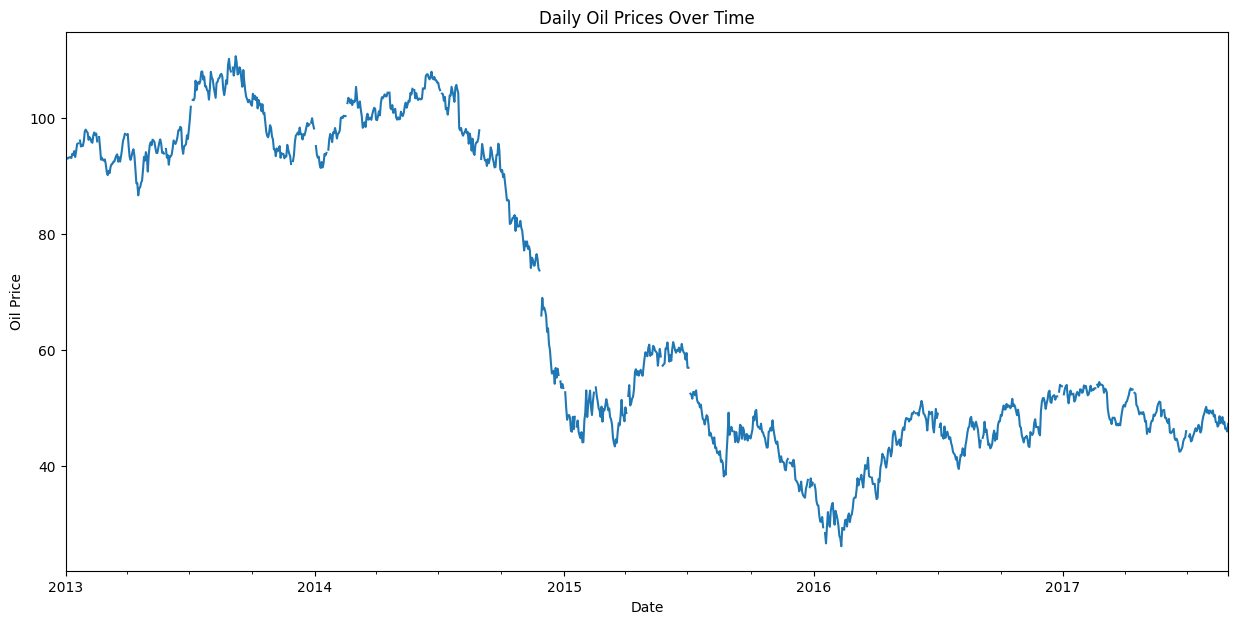

In [47]:
plt.figure(figsize=(15,7))
oil.set_index('date')['dcoilwtico'].plot()
plt.title('Daily Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.show()

## **Transactions Over Time**

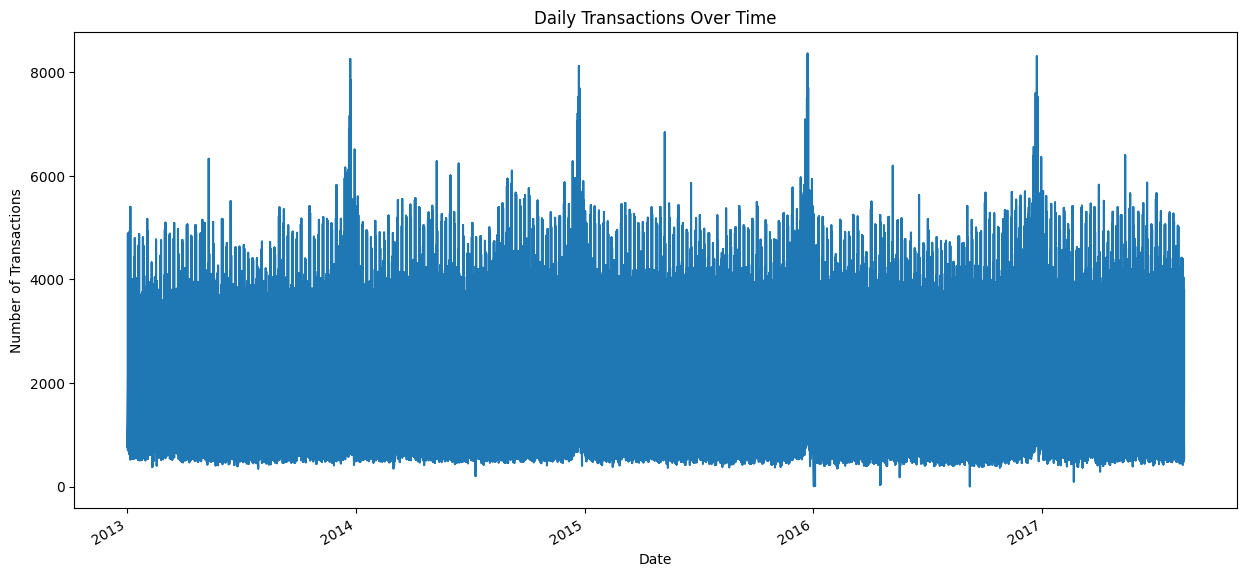

In [48]:
plt.figure(figsize=(15,7))
transactions.set_index('date')['transactions'].plot()
plt.title('Daily Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.show()

# **Data Cleaning**

## **Merge Oil Prices and Handle Duplicate Columns**

In [49]:
### Feature Engineering - Merge Oil Prices and Handle Duplicate Columns

# Merge oil prices with train and test datasets
train = pd.merge(train, oil, on='date', how='left', suffixes=('', '_y'))
test = pd.merge(test, oil, on='date', how='left', suffixes=('', '_y'))

# Check the columns after merging
print("Columns in train after merge:", train.columns.tolist())
print("Columns in test after merge:", test.columns.tolist())

# Consolidate 'dcoilwtico' columns in train
if 'dcoilwtico' in train.columns and 'dcoilwtico_y' in train.columns:
    # Fill missing values in 'dcoilwtico' with 'dcoilwtico_y'
    train['dcoilwtico'] = train['dcoilwtico'].fillna(train['dcoilwtico_y'])
    # Drop the duplicate column
    train.drop('dcoilwtico_y', axis=1, inplace=True)
    print("Consolidated 'dcoilwtico' in train.")
elif 'dcoilwtico_y' in train.columns:
    # Rename 'dcoilwtico_y' to 'dcoilwtico'
    train.rename(columns={'dcoilwtico_y': 'dcoilwtico'}, inplace=True)
    print("Renamed 'dcoilwtico_y' to 'dcoilwtico' in train.")
else:
    print("'dcoilwtico' column is present without duplicates in train.")

# Consolidate 'dcoilwtico' columns in test
if 'dcoilwtico' in test.columns and 'dcoilwtico_y' in test.columns:
    # Fill missing values in 'dcoilwtico' with 'dcoilwtico_y'
    test['dcoilwtico'] = test['dcoilwtico'].fillna(test['dcoilwtico_y'])
    # Drop the duplicate column
    test.drop('dcoilwtico_y', axis=1, inplace=True)
    print("Consolidated 'dcoilwtico' in test.")
elif 'dcoilwtico_y' in test.columns:
    # Rename 'dcoilwtico_y' to 'dcoilwtico'
    test.rename(columns={'dcoilwtico_y': 'dcoilwtico'}, inplace=True)
    print("Renamed 'dcoilwtico_y' to 'dcoilwtico' in test.")
else:
    print("'dcoilwtico' column is present without duplicates in test.")

# Fill missing 'dcoilwtico' with forward fill
if 'dcoilwtico' in train.columns:
    train['dcoilwtico'].fillna(method='ffill', inplace=True)
    test['dcoilwtico'].fillna(method='ffill', inplace=True)
    print("Filled missing 'dcoilwtico' values using forward fill.")
else:
    print("'dcoilwtico' column not found in train or test after consolidation.")

Columns in train after merge: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'dcoilwtico']
Columns in test after merge: ['id', 'date', 'store_nbr', 'family', 'onpromotion', 'dcoilwtico']
'dcoilwtico' column is present without duplicates in train.
'dcoilwtico' column is present without duplicates in test.
Filled missing 'dcoilwtico' values using forward fill.


In [50]:
### Feature Engineering - Prepare Combined Data for Lag Features

# Add 'is_train' flag to distinguish between train and test after concatenation
train['is_train'] = 1
test['is_train'] = 0

# For test set, set 'sales' to NaN as it's unknown
test['sales'] = np.nan

# Concatenate train and test datasets
combined = pd.concat([train, test], sort=False)

# Sort combined data by 'store_nbr', 'family', and 'date'
combined = combined.sort_values(['store_nbr', 'family', 'date'])

print("Combined dataset shape:", combined.shape)

Combined dataset shape: (3029400, 8)


In [51]:
### Feature Engineering - Merge Transactions

# Merge transactions with combined dataset
combined = pd.merge(combined, transactions, on=['store_nbr', 'date'], how='left')

# Fill missing 'transactions' with median from training set
median_transactions = combined[combined['is_train'] == 1]['transactions'].median()
combined['transactions'].fillna(median_transactions, inplace=True)

print(f"Merged transactions and filled missing values with median: {median_transactions}")

Merged transactions and filled missing values with median: 1393.0


In [52]:
### Feature Engineering - Create Lag Features on Combined Data

# Create lag features
combined['sales_lag_1'] = combined.groupby(['store_nbr', 'family'])['sales'].shift(1)
combined['sales_lag_7'] = combined.groupby(['store_nbr', 'family'])['sales'].shift(7)
combined['sales_roll_mean_7'] = combined.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(window=7).mean()
combined['sales_roll_std_7'] = combined.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(window=7).std()
combined['promo_last_7'] = combined.groupby(['store_nbr', 'family'])['onpromotion'].shift(1).rolling(window=7).sum()

# Fill missing values in lag features with 0
lag_features = ['sales_lag_1', 'sales_lag_7', 'sales_roll_mean_7', 'sales_roll_std_7']
for feature in lag_features:
    if feature in combined.columns:
        combined[feature].fillna(0, inplace=True)
        print(f"Filled missing values in '{feature}' with 0.")
    else:
        print(f"'{feature}' column not found in combined dataset.")

# Fill 'promo_last_7' with 0
combined['promo_last_7'].fillna(0, inplace=True)
print("Filled missing values in 'promo_last_7' with 0.")

Filled missing values in 'sales_lag_1' with 0.
Filled missing values in 'sales_lag_7' with 0.
Filled missing values in 'sales_roll_mean_7' with 0.
Filled missing values in 'sales_roll_std_7' with 0.
Filled missing values in 'promo_last_7' with 0.


In [53]:
### Feature Engineering - Split Combined Data Back into Train and Test Sets

# Split back into train and test based on 'is_train' flag
train_processed = combined[combined['is_train'] == 1].copy()
test_processed = combined[combined['is_train'] == 0].copy()

# Drop 'is_train' flag
train_processed.drop(['is_train'], axis=1, inplace=True)
test_processed.drop(['is_train'], axis=1, inplace=True)

print("Train_processed shape:", train_processed.shape)
print("Test_processed shape:", test_processed.shape)

Train_processed shape: (3000888, 13)
Test_processed shape: (28512, 13)


In [54]:
### Handle Missing Values in `dcoilwtico` and `transactions`

# Verify if 'transactions' exists in train_processed
if 'transactions' in train_processed.columns:
    print("'transactions' column exists in train_processed.")
    # Check for any remaining missing values
    missing_transactions_train = train_processed['transactions'].isnull().sum()
    print(f"Missing 'transactions' in train_processed: {missing_transactions_train}")
else:
    print("'transactions' column is missing in train_processed.")

# Similarly, verify 'transactions' in test_processed
if 'transactions' in test_processed.columns:
    print("'transactions' column exists in test_processed.")
    # Check for any remaining missing values
    missing_transactions_test = test_processed['transactions'].isnull().sum()
    print(f"Missing 'transactions' in test_processed: {missing_transactions_test}")
else:
    print("'transactions' column is missing in test_processed.")

'transactions' column exists in train_processed.
Missing 'transactions' in train_processed: 0
'transactions' column exists in test_processed.
Missing 'transactions' in test_processed: 0


# **Feature Engineering**

In [55]:
### Feature Engineering - Encode Categorical Variables

# Initialize LabelEncoder
le = LabelEncoder()

# List of categorical columns to encode
categorical_cols = ['family', 'city', 'state', 'type', 'cluster']

# Encode each categorical column
for col in categorical_cols:
    if col in train_processed.columns:
        train_processed[col] = le.fit_transform(train_processed[col])
        test_processed[col] = le.transform(test_processed[col])
        print(f"Encoded '{col}' column.")
    else:
        print(f"'{col}' column not found in train or test datasets.")

Encoded 'family' column.
'city' column not found in train or test datasets.
'state' column not found in train or test datasets.
'type' column not found in train or test datasets.
'cluster' column not found in train or test datasets.


In [56]:
### Feature Scaling - Scale Numerical Features

# List of numerical features to scale
numerical_features = ['onpromotion', 'dcoilwtico', 'transactions', 'sales_lag_1', 
                      'sales_lag_7', 'sales_roll_mean_7', 'sales_roll_std_7', 'promo_last_7']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler on training data and transform training and test sets
train_processed[numerical_features] = scaler.fit_transform(train_processed[numerical_features])
test_processed[numerical_features] = scaler.transform(test_processed[numerical_features])

print("Scaled numerical features in training and test sets.")

Scaled numerical features in training and test sets.


In [57]:
### Define Target and Features

# Check if 'sales_log' exists; if not, create it
if 'sales_log' not in train_processed.columns:
    # Apply log transformation to handle skewness
    train_processed['sales_log'] = np.log1p(train_processed['sales'])
    print("'sales_log' column created using log transformation.")

# Define target variable
y = train_processed['sales_log']

# Define feature set by dropping unnecessary columns
X = train_processed.drop(['id', 'date', 'sales', 'sales_log'], axis=1)

print("Defined target and feature sets.")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

'sales_log' column created using log transformation.
Defined target and feature sets.
Features shape: (3000888, 10)
Target shape: (3000888,)


In [58]:
### Split into Training and Validation Sets

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Split data into training and validation sets.")
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

Split data into training and validation sets.
Training set size: (2400710, 10)
Validation set size: (600178, 10)


In [59]:
### Handle Remaining Missing Values Using SimpleImputer

# Initialize the imputer with median strategy
imputer = SimpleImputer(strategy='median')

# Fit the imputer on training data and transform training and validation sets
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns, index=X_val.index)

# For test_processed, ensure to drop non-feature columns before imputation
# Identify non-feature columns
non_feature_cols = ['id', 'date', 'sales', 'sales_log']

# Drop non-feature columns from test_processed if present
test_features = test_processed.drop(non_feature_cols, axis=1, errors='ignore')

# Impute the test features
test_features_imputed = pd.DataFrame(imputer.transform(test_features), columns=test_features.columns, index=test_features.index)

# Replace the imputed features back into test_processed
test_scaled = test_features_imputed.copy()

print("Handled remaining missing values using SimpleImputer.")

Handled remaining missing values using SimpleImputer.


In [60]:
### Verify No Missing Values Remain

# Verify that there are no missing values in imputed datasets
print("Missing values in X_train_imputed after filling:")
print(X_train_imputed.isnull().sum())

print("\nMissing values in X_val_imputed after filling:")
print(X_val_imputed.isnull().sum())

print("\nMissing values in test_scaled after filling:")
print(test_scaled.isnull().sum())

Missing values in X_train_imputed after filling:
store_nbr            0
family               0
onpromotion          0
dcoilwtico           0
transactions         0
sales_lag_1          0
sales_lag_7          0
sales_roll_mean_7    0
sales_roll_std_7     0
promo_last_7         0
dtype: int64

Missing values in X_val_imputed after filling:
store_nbr            0
family               0
onpromotion          0
dcoilwtico           0
transactions         0
sales_lag_1          0
sales_lag_7          0
sales_roll_mean_7    0
sales_roll_std_7     0
promo_last_7         0
dtype: int64

Missing values in test_scaled after filling:
store_nbr            0
family               0
onpromotion          0
dcoilwtico           0
transactions         0
sales_lag_1          0
sales_lag_7          0
sales_roll_mean_7    0
sales_roll_std_7     0
promo_last_7         0
dtype: int64


In [61]:
### Modeling - Random Forest Regressor

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the model on the imputed training data
rf.fit(X_train_imputed, y_train)

# Predict on the imputed validation set
y_pred_rf = rf.predict(X_val_imputed)

# Calculate evaluation metrics
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
mae_rf = mean_absolute_error(y_val, y_pred_rf)

# Print the results
print(f"Random Forest RMSE: {rmse_rf:.4f}")
print(f"Random Forest MAE: {mae_rf:.4f}")

KeyboardInterrupt: 

In [62]:
### Modeling - Gradient Boosting Regressor

# Initialize the Gradient Boosting Regressor
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, 
                               max_depth=5, random_state=42)

# Fit the model on the imputed training data
gb.fit(X_train_imputed, y_train)

# Predict on the imputed validation set
y_pred_gb = gb.predict(X_val_imputed)

# Calculate evaluation metrics
rmse_gb = np.sqrt(mean_squared_error(y_val, y_pred_gb))
mae_gb = mean_absolute_error(y_val, y_pred_gb)

# Print the results
print(f"Gradient Boosting RMSE: {rmse_gb:.4f}")
print(f"Gradient Boosting MAE: {mae_gb:.4f}")

KeyboardInterrupt: 

In [63]:
### Modeling - XGBoost Regressor

# Initialize the XGBoost Regressor
xgbr = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, 
                       max_depth=5, random_state=42, n_jobs=-1)

# Fit the model on the imputed training data
xgbr.fit(X_train_imputed, y_train)

# Predict on the imputed validation set
y_pred_xgbr = xgbr.predict(X_val_imputed)

# Calculate evaluation metrics
rmse_xgbr = np.sqrt(mean_squared_error(y_val, y_pred_xgbr))
mae_xgbr = mean_absolute_error(y_val, y_pred_xgbr)

# Print the results
print(f"XGBoost RMSE: {rmse_xgbr:.4f}")
print(f"XGBoost MAE: {mae_xgbr:.4f}")

XGBoost RMSE: 0.4551
XGBoost MAE: 0.2644


In [64]:
### Evaluation

# Create a DataFrame to compare model performances
evaluation_df = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost'],
    'RMSE': [rmse_rf, rmse_gb, rmse_xgbr],
    'MAE': [mae_rf, mae_gb, mae_xgbr]
})

# Display the evaluation results
print(evaluation_df)

NameError: name 'rmse_rf' is not defined

In [65]:
### Prediction & Submission - Final Model Training

# Initialize the final XGBoost Regressor
final_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, 
                              max_depth=5, random_state=42, n_jobs=-1)

# Define the full training data
final_X = X_train_imputed
final_y = y_train

# Fit the final model on the entire training data
final_model.fit(final_X, final_y)

print("Final model trained on the entire training dataset.")

Final model trained on the entire training dataset.


In [66]:
### Prediction & Submission - Prepare Test Data

# Prepare test features by dropping unnecessary columns
test_features = test_scaled.copy()

# Ensure that test_features only contains feature columns
print("Columns in test_features:", test_features.columns.tolist())

Columns in test_features: ['store_nbr', 'family', 'onpromotion', 'dcoilwtico', 'transactions', 'sales_lag_1', 'sales_lag_7', 'sales_roll_mean_7', 'sales_roll_std_7', 'promo_last_7']


In [67]:
### Prediction & Submission - Make Predictions

# Make predictions on the test set
test_pred_log = final_model.predict(test_features)

# Inverse the log transformation
test_pred = np.expm1(test_pred_log)

# Ensure no negative sales predictions
test_pred = np.where(test_pred < 0, 0, test_pred)

print("Predictions on the test set completed.")

Predictions on the test set completed.


In [68]:
### Prediction & Submission - Prepare Submission File

# Create the submission DataFrame
submission = pd.DataFrame({
    'id': test_processed['id'],
    'sales': test_pred
})

# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)

# Display the first few rows of the submission file
print("Submission file 'submission.csv' created successfully:")
display(submission.head())

Submission file 'submission.csv' created successfully:


,id,sales
1684,3000888,2.592138
1685,3002670,0.000000
1686,3004452,0.027098
1687,3006234,0.066812
1688,3008016,0.027098
